In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUT_FIG = Path("../outputs/figures").resolve()
OUT_FIG.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

PROC = Path("../data/processed").resolve()
mart = pd.read_csv(PROC / "mart_orders.csv", parse_dates=[
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_created",
], low_memory=False)

kpi_month = pd.read_csv(PROC / "kpi_month.csv")
delay_vs_review = pd.read_csv(PROC / "delay_vs_review.csv")

# дебаг
kpi_month["purchase_month"] = kpi_month["purchase_month"].astype(str)

# уборка неполных месяцев
kpi_month_clean = kpi_month[kpi_month["orders"] >= 100].copy()

# сортировка
kpi_month_clean = kpi_month_clean.sort_values("purchase_month")

print(mart.shape, kpi_month.shape, delay_vs_review.shape)


(99441, 32) (25, 11) (9, 6)


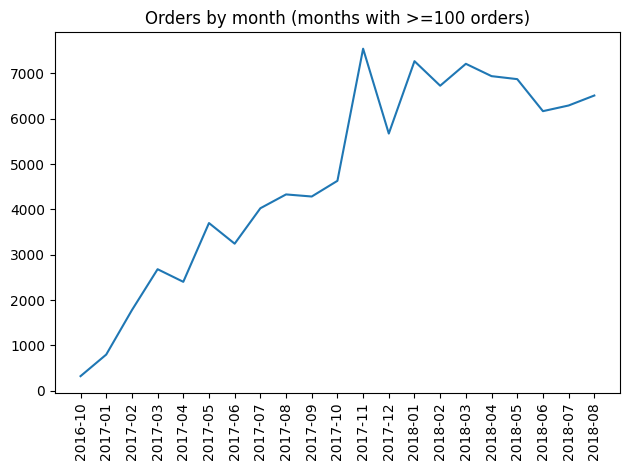

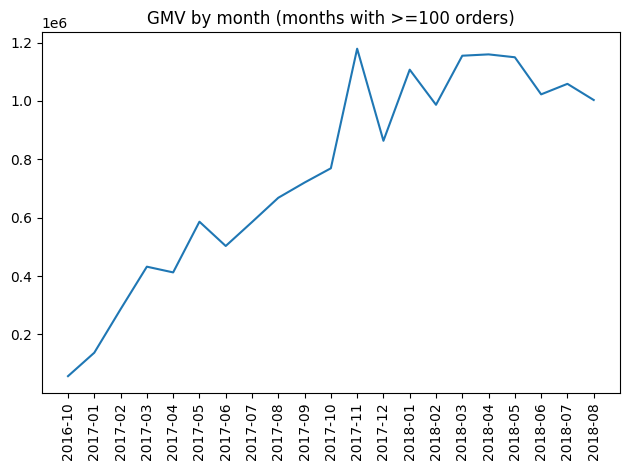

In [12]:
plt.figure()
plt.plot(kpi_month_clean["purchase_month"], kpi_month_clean["orders"])
plt.xticks(rotation=90)
plt.title("Orders by month (months with >=100 orders)")
plt.tight_layout()
plt.savefig(OUT_FIG / "orders_by_month.png", bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(kpi_month_clean["purchase_month"], kpi_month_clean["gmv"])
plt.xticks(rotation=90)
plt.title("GMV by month (months with >=100 orders)")
plt.tight_layout()
plt.savefig(OUT_FIG / "gmv_by_month.png", bbox_inches="tight")
plt.show()


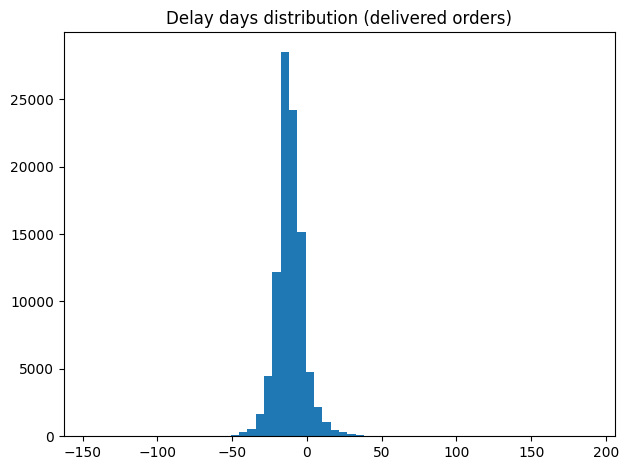

In [13]:
delivered = mart[mart["delivered"] == True].copy()
plt.figure()
plt.hist(delivered["delay_days"].dropna(), bins=60)
plt.title("Delay days distribution (delivered orders)")
plt.tight_layout()
plt.savefig(OUT_FIG / "delay_days_dsrbn.png", bbox_inches="tight")
plt.show()


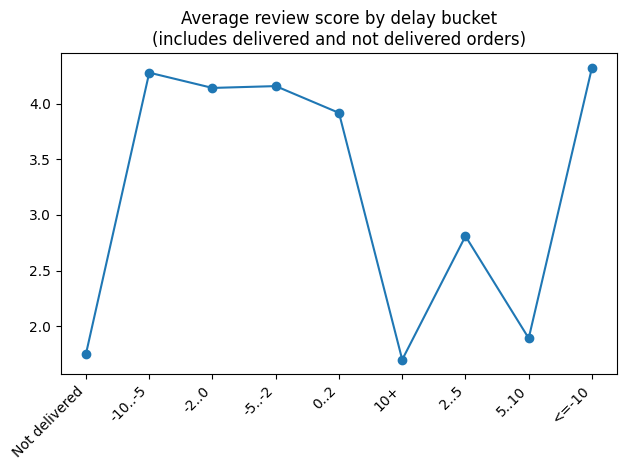

In [14]:
# График включает как доставленные (delivered=True), так и недоставленные (delivered=False) заказы
plt.figure()
plt.plot(delay_vs_review["delay_bucket"], delay_vs_review["avg_review"], marker="o")
plt.title("Average review score by delay bucket\n(includes delivered and not delivered orders)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(OUT_FIG / "avrg_rw_score.png", bbox_inches="tight")
plt.show()


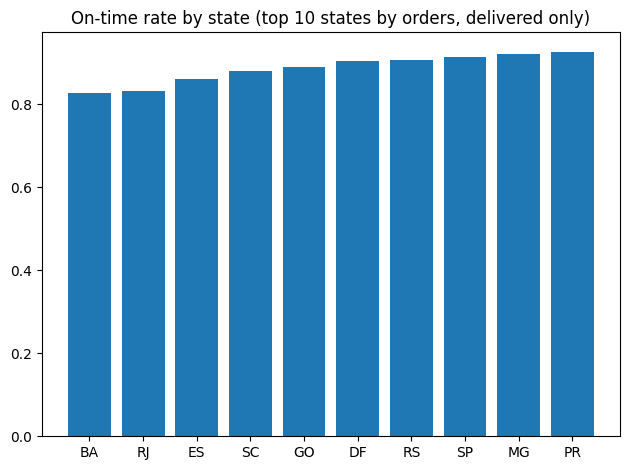

,customer_state,orders,delivered_rate,on_time_rate,avg_delay
4,BA,3380,0.963314,0.828107,-10.099073
18,RJ,12852,0.961173,0.831699,-11.060399
7,ES,2033,0.981308,0.861289,-9.797109
23,SC,3637,0.975254,0.880121,-10.806692
8,GO,2020,0.968812,0.889604,-11.483577
6,DF,2140,0.971963,0.903271,-11.339525
22,RS,5466,0.977680,0.907794,-13.208489
25,SP,41746,0.970033,0.912854,-10.381190
10,MG,11635,0.975935,0.921100,-12.536991
17,PR,5045,0.975818,0.927056,-12.619678


In [15]:
# Статистика по штатам с учетом как доставленных, так и недоставленных заказов
state_stats = (
    mart.groupby("customer_state", as_index=False)
    .agg(
        orders=("order_id", "nunique"),
        delivered_rate=("delivered", "mean"),
        on_time_rate=("on_time", "mean"),  # только для доставленных
        avg_delay=("delay_days", "mean"),  # только для доставленных
    )
)

top_states = state_stats.sort_values("orders", ascending=False).head(10)
top_states = top_states.sort_values("on_time_rate", ascending=True)

plt.figure()
plt.bar(top_states["customer_state"], top_states["on_time_rate"])
plt.title("On-time rate by state (top 10 states by orders, delivered only)")
plt.tight_layout()
plt.savefig(OUT_FIG / "ontime_rate_state.png", bbox_inches="tight")
plt.show()

# Показываем таблицу с информацией о доставленных и недоставленных заказах
top_states


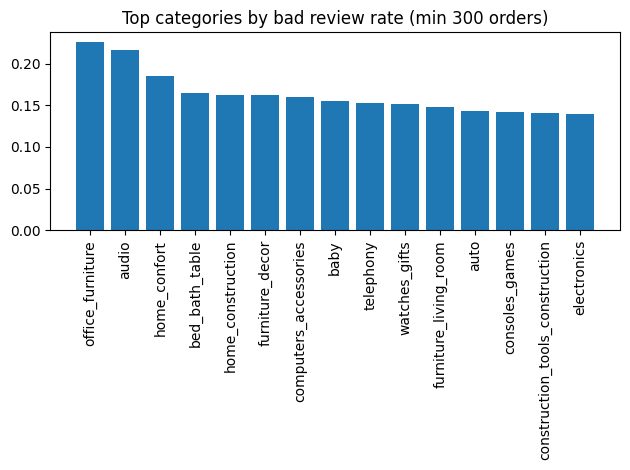

,category_main,orders,delivered_rate,bad_review_rate,avg_review,avg_delay
57,office_furniture,1260,0.984921,0.226190,3.618651,-11.154118
4,audio,343,0.994169,0.215743,3.841108,-9.342959
47,home_confort,357,0.985994,0.184874,3.904762,-8.990865
7,bed_bath_table,9247,0.985401,0.164486,3.978480,-10.697621
48,home_construction,474,0.987342,0.162447,4.014768,-10.521531
39,furniture_decor,6283,0.978036,0.161865,4.028012,-11.612718
15,computers_accessories,6631,0.977379,0.159704,4.027522,-11.697179
6,baby,2809,0.973656,0.155215,4.055358,-10.833943
68,telephony,4148,0.976133,0.152845,4.010125,-10.542820
70,watches_gifts,5559,0.977694,0.151286,4.067458,-11.126155


In [16]:
# Статистика по категориям с учетом как доставленных, так и недоставленных заказов
tmp = mart[mart["review_score"].notna()].copy()
cat_stats = (
    tmp.groupby("category_main", as_index=False)
    .agg(
        orders=("order_id", "nunique"),
        delivered_rate=("delivered", "mean"),  # доля доставленных заказов
        bad_review_rate=("bad_review", "mean"),
        avg_review=("review_score", "mean"),
        avg_delay=("delay_days", "mean"),  # только для доставленных
    )
)

cat_stats = cat_stats[cat_stats["orders"] >= 300].sort_values("bad_review_rate", ascending=False).head(15)

plt.figure()
plt.bar(cat_stats["category_main"], cat_stats["bad_review_rate"])
plt.xticks(rotation=90)
plt.title("Top categories by bad review rate (min 300 orders)")
plt.tight_layout()
plt.savefig(OUT_FIG / "top_cat_bad_review.png", bbox_inches="tight")
plt.show()

cat_stats
